# Dev-two notebook for analysis

## We've already assembled our data, so lets look at it closer and decide how we can maybe refine it for further testing on regression algorithms, or how we can change it for use in classifier algorithms.

### 1. Further analysis

In [309]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [310]:
# Let's reassemble the database without any normalizing.
df_weather = pd.read_csv('weather_cleaned.csv')
df_crashes = pd.read_csv('df_denver_severity_by_dates.csv')
df_crashes['DATE'] = pd.to_datetime(df_crashes['DATE'])
df_weather['DATE'] = pd.to_datetime(df_weather['DATE'])

def find_fix_dates(weather_df, crash_df):
    for row in weather_df.index:
        weather_date = weather_df.at[row, 'DATE']
        crash_date = crash_df.at[row, 'DATE']
        if str(weather_date) != str(crash_date):
            print(f"Fixing {row} - {weather_date}")
            crash_df.loc[len(crash_df.index)] = [weather_date, 0, 0, 0, 0, 0, 0]
            crash_df.sort_values(by=['DATE'], axis=0, inplace=True)
            crash_df.reset_index(drop=True, inplace=True)
            find_fix_dates(weather_df, crash_df)
        else:
            pass

    crash_df['YEAR'] = crash_df.DATE.dt.year
    crash_df['MONTH'] = crash_df.DATE.dt.month
    crash_df['DAY'] = crash_df.DATE.dt.day
    crash_df['DAYOFWEEK'] = crash_df.DATE.dt.day_of_week

find_fix_dates(df_weather, df_crashes)

df = pd.concat([df_weather, df_crashes.drop('DATE', axis=1)], axis=1)

Fixing 1520 - 2011-03-01 00:00:00


In [311]:
# The data in the WT_* categories is too sparse to be of any use, so let's dump all of those.
df = df[df.columns.drop(list(df.filter(regex='WT_')))]

In [312]:
# Year, month, and day seem like they won't be very useful as they'll change with every row. However, 'DAYOFWEEK' could be very significant since traffic patterns change based off of that. Similarly, 'DATE' seems to be irrelevant since it's unique for every row.
df = df.drop(['DATE', 'YEAR', 'MONTH', 'DAY'], axis=1)

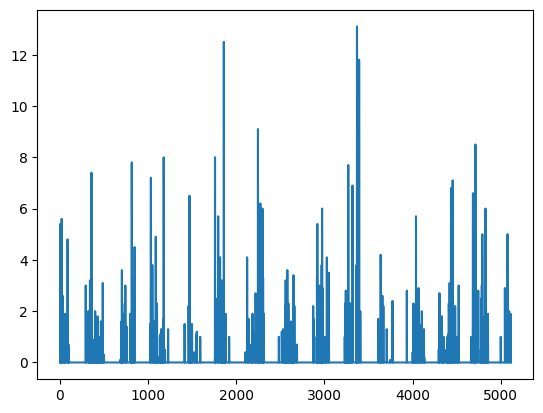

In [313]:
plt.plot(df['SNOWFALL'])

In [314]:
# The features that now remain feel like they could all play a factor, so let's toss this through a quick RandomForestRegression() and see if we get anything different.

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer
#
# X = df.drop(['TOTAL_SEVERITY'], axis=1)
# y = df['TOTAL_SEVERITY']
#
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#
# model = RandomForestRegressor(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)
# model.score(X_test, y_test)
# print(f'R2 Score: {np.mean(cross_val_score(model, X, y, cv=5, scoring="r2"))*100:.2f}%')

In [315]:
# All of our regression models have failed so far. Now there's some things we could do, but I'd like to try thinking of this in terms of a classification problem. Maybe multiple classification, with 5 categories of severity:

# Extreme
# High
# Moderate
# Low
# Lowest

# We could look at the spectrum of severity and then sort it into categories.

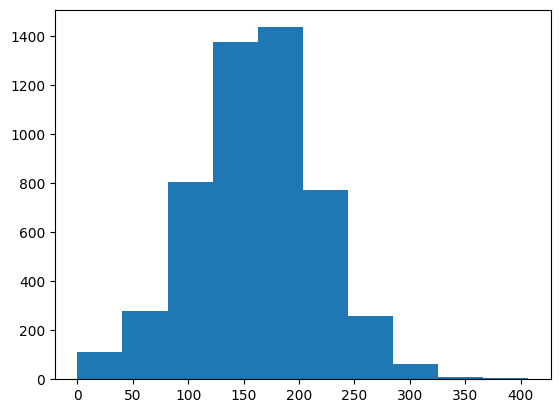

In [316]:
plt.hist(df['TOTAL_SEVERITY'])
plt.show()

In [317]:
# Thankfully we have a nice distribution of severity data.

In [318]:
def sort_severity(passed_df):
    from sklearn.preprocessing import minmax_scale
    passed_df['SEVERITY_NORMALIZED'] = minmax_scale(passed_df['TOTAL_SEVERITY'])
    for row in passed_df.index:
        severity_normalized = float(passed_df.at[row, 'SEVERITY_NORMALIZED'])
        if severity_normalized <= 0.20:
            passed_df.at[row, 'SEVERITY_CLASSIFICATION'] = 1
        elif severity_normalized > 0.20 and severity_normalized <= 0.40:
            passed_df.at[row, 'SEVERITY_CLASSIFICATION'] = 2
        elif severity_normalized > 0.40 and severity_normalized <= 0.60:
            passed_df.at[row, 'SEVERITY_CLASSIFICATION'] = 3
        elif severity_normalized > 0.60 and severity_normalized <= 0.80:
            passed_df.at[row, 'SEVERITY_CLASSIFICATION'] = 4
        elif severity_normalized > 0.80 and severity_normalized <= 1.00:
            passed_df.at[row, 'SEVERITY_CLASSIFICATION'] = 5
    passed_df['SEVERITY_CLASSIFICATION'] = passed_df['SEVERITY_CLASSIFICATION'].astype('int64')

In [319]:
sort_severity(df)

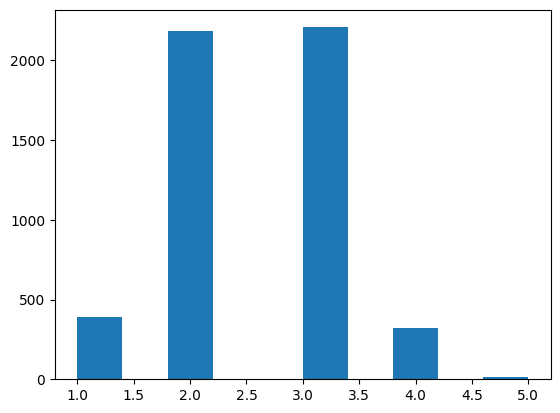

In [320]:
plt.hist(df['SEVERITY_CLASSIFICATION'])
plt.show()

In [321]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5114 entries, 0 to 5113
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AVG_WIND_SPEED           5114 non-null   float64
 1   PRECIPITATION            5114 non-null   float64
 2   SNOWFALL                 5114 non-null   float64
 3   SNOW_DEPTH               5114 non-null   float64
 4   AVG_TEMP                 5114 non-null   float64
 5   TEMP_MAX                 5114 non-null   float64
 6   TEMP_MIN                 5114 non-null   float64
 7   WIND_2MIN_FASTEST        5114 non-null   float64
 8   WIND_5MIN_FASTEST        5114 non-null   float64
 9   NUMBER_OF_ACCIDENTS      5114 non-null   int64  
 10  TOTAL_SEVERITY           5114 non-null   int64  
 11  DAYOFWEEK                5114 non-null   int64  
 12  SEVERITY_NORMALIZED      5114 non-null   float64
 13  SEVERITY_CLASSIFICATION  5114 non-null   int64  
dtypes: float64(10), int64(4)

In [322]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df.drop(['TOTAL_SEVERITY', 'SEVERITY_CLASSIFICATION', 'SEVERITY_NORMALIZED', 'NUMBER_OF_ACCIDENTS'], axis=1)
y = df['SEVERITY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                    stratify=y,
                                                    random_state=42)

clf = RandomForestClassifier(random_state=42, n_estimators=100, min_samples_split=5,
                            min_samples_leaf=5, max_features=0.5, max_depth=5)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

# This produces the best score seen so far at a coin flip. Let's attempt to tune the model.
# Best score achieved 0.53125

0.53125

In [323]:
# from sklearn.model_selection import RandomizedSearchCV
#
# tuning_params = {'n_estimators': [100, 1000, 5000, 10000],
#                  'max_depth': [None, 3, 5, 10],
#                  'min_samples_split':(2, 5, 10, 20),
#                  'min_samples_leaf': (2, 5, 10, 20),
#                  'max_features': [0.5, 1, "sqrt"]}
#
# gs_clf = RandomizedSearchCV(estimator=clf, n_iter=100, param_distributions=tuning_params, cv=5, verbose=0, n_jobs=-1, random_state=42)
# gs_clf.fit(X, y)

In [324]:
# Maybe having a binary classification would work better. A positive result would be one in which the severity will fall in the upper two categories, or top 40% of severity. Let's also build a severity based off raw severity/accidents.

In [325]:
def binary_severity(passed_df):
    for row in passed_df.index:
        severity_normalized = float(passed_df.at[row, 'SEVERITY_NORMALIZED'])
        try:
            passed_df.at[row, 'SEVERITY_DIVIDED'] = passed_df.at[row, 'TOTAL_SEVERITY'] / passed_df.at[row, 'NUMBER_OF_ACCIDENTS']
        except Exception:
            passed_df.at[row, 'SEVERITY_DIVIDED'] = 0
        if severity_normalized >= 0.60:
            passed_df.at[row, 'SEVERITY_BINARY'] = 1
        else:
            passed_df.at[row, 'SEVERITY_BINARY'] = 0
    passed_df['SEVERITY_BINARY'] = passed_df['SEVERITY_BINARY'].astype('int64')


In [326]:
binary_severity(df)
df.fillna(0, inplace=True)
df_positive_severity = df[df['SEVERITY_BINARY'] == 1]
df.info()

C:\Users\Anthony Garcia\AppData\Local\Temp\ipykernel_28720\3673709716.py:5: RuntimeWarning: invalid value encountered in longlong_scalars
  passed_df.at[row, 'SEVERITY_DIVIDED'] = passed_df.at[row, 'TOTAL_SEVERITY'] / passed_df.at[row, 'NUMBER_OF_ACCIDENTS']


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5114 entries, 0 to 5113
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AVG_WIND_SPEED           5114 non-null   float64
 1   PRECIPITATION            5114 non-null   float64
 2   SNOWFALL                 5114 non-null   float64
 3   SNOW_DEPTH               5114 non-null   float64
 4   AVG_TEMP                 5114 non-null   float64
 5   TEMP_MAX                 5114 non-null   float64
 6   TEMP_MIN                 5114 non-null   float64
 7   WIND_2MIN_FASTEST        5114 non-null   float64
 8   WIND_5MIN_FASTEST        5114 non-null   float64
 9   NUMBER_OF_ACCIDENTS      5114 non-null   int64  
 10  TOTAL_SEVERITY           5114 non-null   int64  
 11  DAYOFWEEK                5114 non-null   int64  
 12  SEVERITY_NORMALIZED      5114 non-null   float64
 13  SEVERITY_CLASSIFICATION  5114 non-null   int64  
 14  SEVERITY_DIVIDED        

In [327]:
df['SEVERITY_BINARY'].value_counts()

0    4781
1     333
Name: SEVERITY_BINARY, dtype: int64

In [328]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df.drop(['TOTAL_SEVERITY', 'SEVERITY_CLASSIFICATION', 'SEVERITY_NORMALIZED', 'SEVERITY_BINARY', 'WIND_2MIN_FASTEST', 'WIND_5MIN_FASTEST', 'NUMBER_OF_ACCIDENTS', 'SEVERITY_DIVIDED'], axis=1)
y = df['SEVERITY_BINARY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

clf = RandomForestClassifier(random_state=42, n_estimators=1000, min_samples_split=2,
                            min_samples_leaf=1, max_features='sqrt', max_depth=None)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9315738025415444

In [329]:
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({'features': columns,
                        'feature_importances': importances})
          .sort_values('feature_importances', ascending=False)
          .reset_index(drop=True)
          )

    fix, ax = plt.subplots()
    ax.barh(df['features'][:n], df['feature_importances'][:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature Importances")
    ax.invert_yaxis()

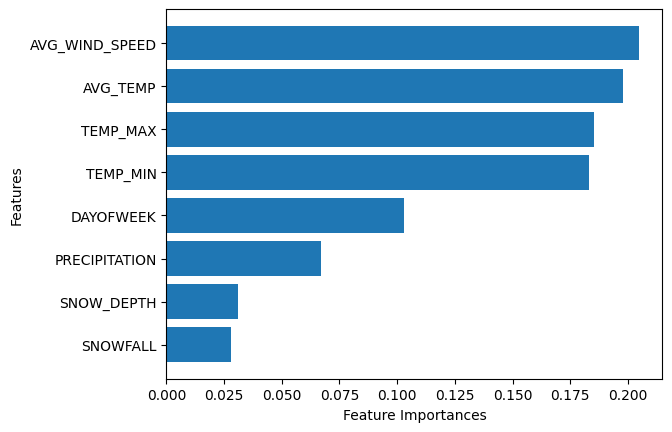

In [330]:
plot_features(X.columns, clf.feature_importances_)

In [331]:
def evaluation_block_classifier(model, X, y, X_test, y_test):

    """
    :param model: name of classifier
    :param X: name of X data (non-target)
    :param y: name of y data (target)
    :param X_test: name of X test data (non-target)
    :param y_test: name of y test data (target)
    :param roc_graph: boolean to determine if ROC graph is plotted and displayed
    """

    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
    from sklearn.model_selection import cross_val_score
    from numpy import mean as npmean
    import matplotlib.pyplot as plt

    # Get y_preds
    preds = model.predict(X_test)

    # Evaluation block for singular metrics (non-cross validated)
    print("Singular classifier metrics on test set:")
    print(f'Accuracy: {accuracy_score(y_test, preds)*100:.2f}%')
    print(f'Precision: {precision_score(y_test, preds)}')
    print(f'Recall: {recall_score(y_test, preds)}')
    print(f'F1: {f1_score(y_test, preds)}')
    print('')

    # Evaluation block for cross val
    print("Cross validation classifier metrics on test set:")
    print(f'Accuracy: {npmean(cross_val_score(model, X, y, cv=5, scoring="accuracy"))*100:.2f}%')
    print(f'Precision: {npmean(cross_val_score(model, X, y, cv=5, scoring="precision"))}')
    print(f'Recall: {npmean(cross_val_score(model, X, y, cv=5, scoring="recall"))}')
    print(f'F1: {npmean(cross_val_score(model, X, y, cv=5, scoring="f1"))}')
    print('')

    y_probs = model.predict_proba(X_test)
    y_probs_positive = y_probs[:, 1]


    # Define and gather data to plot ROC curve

    fpr, tpr, thresholds = roc_curve(y_test, y_probs_positive)

    def plot_roc_curve(fpr, tpr):

        # Plots our ROC curve given the FPR and TPR
        plt.plot(fpr, tpr, color='orange', label="ROC")

        # Plot line with no predictive power (baseline)
        plt.plot([0,1], [0,1], color='darkblue', linestyle='--', label='Guessing')

        # Customize
        plt.xlabel('False positive rate (FPR)')
        plt.ylabel('True positive rate (TPR)')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

    plot_roc_curve(fpr, tpr)
    print(f'ROC AUC score: {roc_auc_score(y_test, y_probs_positive)}')

In [332]:
# evaluation_block_classifier(clf, X, y, X_test, y_test)

In [333]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


X = scaler.fit_transform(df.drop(['TOTAL_SEVERITY', 'SEVERITY_CLASSIFICATION', 'SEVERITY_NORMALIZED', 'SEVERITY_BINARY', 'WIND_2MIN_FASTEST', 'WIND_5MIN_FASTEST', 'NUMBER_OF_ACCIDENTS', 'SEVERITY_DIVIDED'], axis=1))
y = df['SEVERITY_BINARY']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

clf = LinearSVC(random_state=42, max_iter=1000, C=10)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

H:\github\weld-county-weather-accidents\venv310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9345063538611925

In [334]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


X = scaler.fit_transform(df.drop(['TOTAL_SEVERITY', 'SEVERITY_CLASSIFICATION', 'SEVERITY_NORMALIZED', 'SEVERITY_BINARY', 'WIND_2MIN_FASTEST', 'WIND_5MIN_FASTEST', 'NUMBER_OF_ACCIDENTS', 'SEVERITY_DIVIDED'], axis=1))
y = df['SEVERITY_BINARY']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9345063538611925

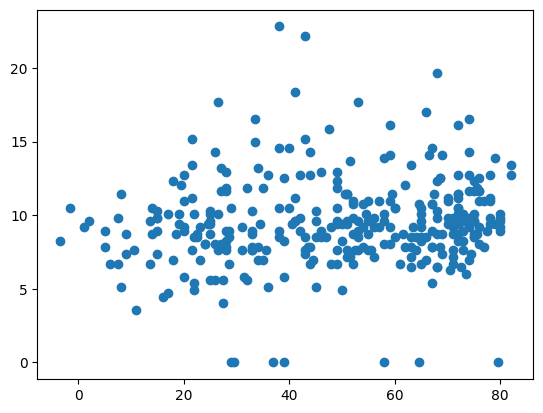

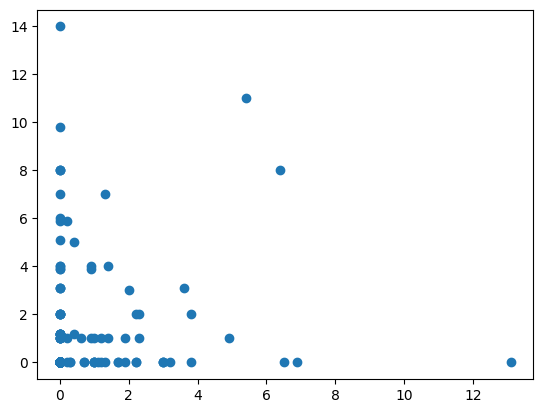

In [335]:
# plt.scatter(df['AVG_TEMP'], df['AVG_WIND_SPEED'], c=df['SEVERITY_BINARY'])
# plt.show()
# plt.scatter(df['SNOWFALL'], df['SNOW_DEPTH'], c=df['SEVERITY_BINARY'])
# plt.show()
# plt.scatter(df['TEMP_MIN'], df['SNOWFALL'], c=df['SEVERITY_BINARY'])
# plt.show()
# plt.scatter(df['AVG_TEMP'], df['SNOWFALL'], c=df['SEVERITY_BINARY'])
# plt.show()
plt.scatter(df_positive_severity['AVG_TEMP'], df_positive_severity['AVG_WIND_SPEED'])
plt.show()
plt.scatter(df_positive_severity['SNOWFALL'], df_positive_severity['SNOW_DEPTH'])
plt.show()

In [336]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()


X = scaler.fit_transform(df.drop(['TOTAL_SEVERITY', 'SEVERITY_CLASSIFICATION', 'SEVERITY_NORMALIZED', 'SEVERITY_BINARY', 'WIND_2MIN_FASTEST', 'WIND_5MIN_FASTEST', 'NUMBER_OF_ACCIDENTS', 'SEVERITY_DIVIDED'], axis=1))
y = df['SEVERITY_BINARY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

clf = SVC(kernel='rbf', random_state=42, max_iter=20000)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9345063538611925

In [337]:
# Now let's use our severity divided

In [341]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

X = scaler.fit_transform(df.drop(['TOTAL_SEVERITY', 'SEVERITY_CLASSIFICATION', 'SEVERITY_NORMALIZED', 'SEVERITY_BINARY', 'WIND_2MIN_FASTEST', 'WIND_5MIN_FASTEST', 'NUMBER_OF_ACCIDENTS', 'SEVERITY_DIVIDED'], axis=1))
y = df['SEVERITY_DIVIDED']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestRegressor(random_state=42, n_estimators=100)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

-0.08848000946119061